In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict

from dotenv import load_dotenv
load_dotenv()

# data selection imports
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [3]:
start =  datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2C02'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
SS1_path = data_root + "data/nw2/tracked_modes/SS1_" + name_location  + ".parquet"
SS2_path = data_root + "data/nw2/tracked_modes/SS2_" + name_location  + ".parquet"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
SS1_tracked = pd.read_parquet(SS1_path)
SS2_tracked = pd.read_parquet(SS2_path)

SS1_sorted = SS1_tracked.sort_values(['timestamp', 'size'])
SS1_sorted[SS1_sorted.index.duplicated(keep='last')]
SS1_drop_duplicates = SS1_sorted[~SS1_sorted.index.duplicated(keep='last')]

SS2_sorted = SS2_tracked.sort_values(['timestamp', 'size'])
SS2_sorted[SS2_sorted.index.duplicated(keep='last')]
SS2_drop_duplicates = SS2_sorted[~SS2_sorted.index.duplicated(keep='last')]

SS1_frequency = SS1_drop_duplicates.frequency
SS2_frequency = SS2_drop_duplicates.frequency

scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

selected_columns = \
    [
       #'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw',
       'mean_NW2_C02_pitch',
       'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'
    ]
inputs = inputs[selected_columns]

# SS1 model selection

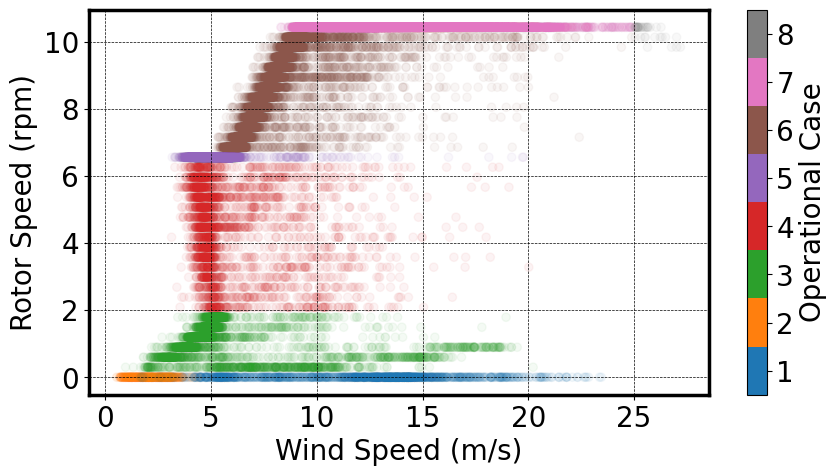

In [4]:
### Multiple Linear Regression
# define the 6 operational cases

inputs['operational_case'] = np.nan

cutout_windspeed = 25
pitch1 = 72
rpm1 = 1.9
rpm2 = 6.5
rpm3 = 6.8
rpm4 = 10.2


# Case 1: parked/idling + pitch > 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] <= 0) & (inputs['mean_NW2_C02_pitch'] > pitch1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    1,
    inputs['operational_case']
)

# Case 2: parked/idling + pitch < 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] <= 0) & (inputs['mean_NW2_C02_pitch'] < pitch1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    2,
    inputs['operational_case']
)

# Case 3: transition1: 0 < rpm < 1.9
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] > 0) & (inputs['mean_NW2_C02_rpm'] < rpm1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    3,
    inputs['operational_case']
)

# Case 4: transition2: 1.9 < rpm < 6.8
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] > rpm1) & (inputs['mean_NW2_C02_rpm'] < rpm2) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    4,
    inputs['operational_case']
)

# Case 5: start operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm2) & (inputs['mean_NW2_C02_rpm'] < rpm3) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    5,
    inputs['operational_case']
)

# Case 6: operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm3) & (inputs['mean_NW2_C02_rpm'] < rpm4) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    6,
    inputs['operational_case']
)

# Case 7: operating: rpm > rpm4
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm4) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    7,
    inputs['operational_case']
)

# Case 8: cutout: windspeed > cutout_windspeed
inputs['operational_case'] = np.where(
    inputs['mean_NW2_C02_windspeed'] > cutout_windspeed,
    8,
    inputs['operational_case']
)

import matplotlib

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(inputs['mean_NW2_C02_windspeed'], inputs['mean_NW2_C02_rpm'], alpha=0.05, c=inputs['operational_case'], cmap=cmap)
# Add the colorbar with alpha = 1
cbar = plt.colorbar()
cbar.ax.set_ylabel('Operational Case')
cbar.set_alpha(1)
cbar.draw_all()
tick_locs = np.linspace(int(inputs['operational_case'].min()), int(inputs['operational_case'].max()), int(2 * len(inputs['operational_case'].unique()) -1 ))[1::2]
cbar_tick_label = np.arange(int(inputs['operational_case'].min()), int(inputs['operational_case'].max() + 1))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(cbar_tick_label)

# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Rotor Speed (rpm)')
plt.show()

In [5]:
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

prediction_param = SS1_frequency.copy()
y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 


7.0
(1278, 10) (1278,)
R2:  0.013565149426281398 MSE:  9.663135477181445e-06
6.0
(9945, 10) (9945,)
R2:  0.16793116056376034 MSE:  5.6449790081536215e-06
5.0
(4574, 10) (4574,)
R2:  0.04309908389384609 MSE:  2.6673703413042402e-06
4.0
(1087, 10) (1087,)
R2:  0.05734222559295887 MSE:  2.7658538979209798e-06
3.0
(1638, 10) (1638,)
R2:  0.029826484915035367 MSE:  6.671430236914187e-06
2.0
(380, 10) (380,)
R2:  0.03472180316096851 MSE:  6.0937552883356965e-06
1.0
(1288, 10) (1288,)
R2:  0.019108466880164765 MSE:  7.356722871850367e-06
8.0
(21, 10) (21,)
R2:  -1.6564740001801819 MSE:  3.3879187187420916e-06
Overall R2:  0.09889434864941106
Overall MSE:  5.268708801828768e-06
R2:  0.5155210003716449
R2:  0.5105231297333581


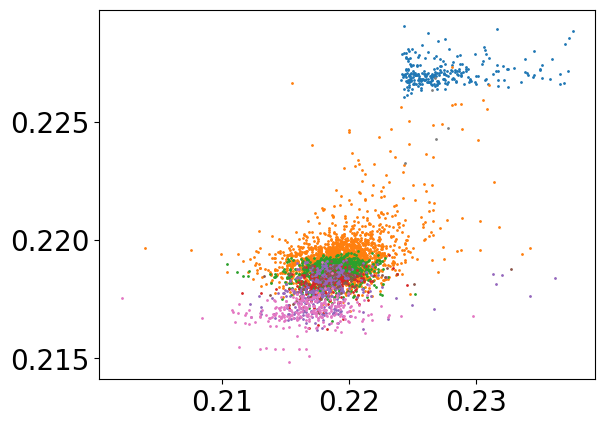

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
mode = 'SS1'
df = inputs.copy().dropna()
random_state = 24
test_size = 0.2

prediction_param = SS1_frequency.copy()

operational_cases = df['operational_case'].unique()

# Train Linear Regression Models for Each Case

linear_regression_models = {}
predictions = {}
r2 = {}
mean_squared_errors = {}
y = prediction_param.dropna()
common_indices = df.index.intersection(y.index)
df_case = df.loc[common_indices]
y_test_cases = {}
predictions_full = {}

for case in operational_cases:
    print(case)
    
    # Filter the dataset for the current operational case
    case_data = df_case[df_case['operational_case'] == case]
    
    # Split the data into input features (X) and target variable (y)
    y = prediction_param.dropna()
    X = case_data.drop(['operational_case'], axis=1).dropna()
    y = y.loc[X.index]
    print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state)
    y_test_cases[case] = y_test
    # Train a linear regression model for the current case
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    
    # Store the trained linear regression model for the current case
    linear_regression_models[case] = linear_regression
    predictions[case] = pd.Series(linear_regression_models[case].predict(X_test), index=y_test.index)
    predictions_full[case] = pd.Series(linear_regression_models[case].predict(X), index=y.index)

    r2[case] = r2_score(y_test, predictions[case])
    mean_squared_errors[case] = mean_squared_error(y_test, predictions[case])
    print('R2: ', r2[case], 'MSE: ', mean_squared_errors[case])
    plt.scatter(y_test, predictions[case], alpha=1, s=1)

# Calculate the overall R2 and MSE for the linear regression model through weighted averaging
r2_overall = 0
mse_overall = 0
predictions_ts = pd.Series()
y_test_ts = pd.Series()
predictions_full_ts = pd.Series()
for case in operational_cases:
    r2_overall += r2[case] * len(df_case[df_case['operational_case'] == case])
    mse_overall += mean_squared_errors[case] * len(df_case[df_case['operational_case'] == case])
    predictions_ts = pd.concat([predictions_ts, predictions[case]])
    y_test_ts = pd.concat([y_test_ts, y_test_cases[case]])
    predictions_full_ts = pd.concat([predictions_full_ts, predictions_full[case]])

r2_overall /= len(df_case)
mse_overall /= len(df_case)

print('Overall R2: ', r2_overall)
print('Overall MSE: ',mse_overall)


y = prediction_param.dropna()
X = inputs.copy().drop(['operational_case'], axis=1).loc[y.index].dropna()
y = y.loc[X.index]

predictions_ts.sort_index(inplace=True)
predictions_full_ts.sort_index(inplace=True)
y_test_ts.sort_index(inplace=True)
print('R2: ', r2_score(y_test_ts, predictions_ts))
print('R2: ', r2_score(y, predictions_full_ts))

In [8]:
X.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'mean_NW2_C02_winddirection'],
      dtype='object')

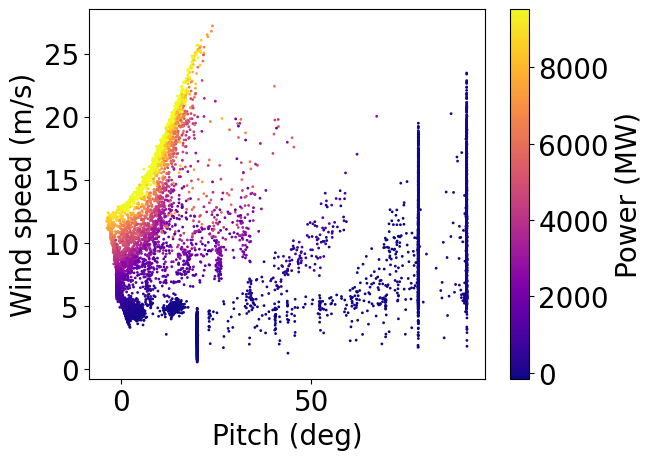

In [9]:
plt.scatter(X['mean_NW2_C02_pitch'], X['mean_NW2_C02_windspeed'], c=X['mean_NW2_C02_power'], s=1, alpha=1.0, cmap='plasma')
plt.xlabel('Pitch (deg)')
plt.ylabel('Wind speed (m/s)')
cbar = plt.colorbar()
cbar.set_label('Power (MW)')
plt.show()

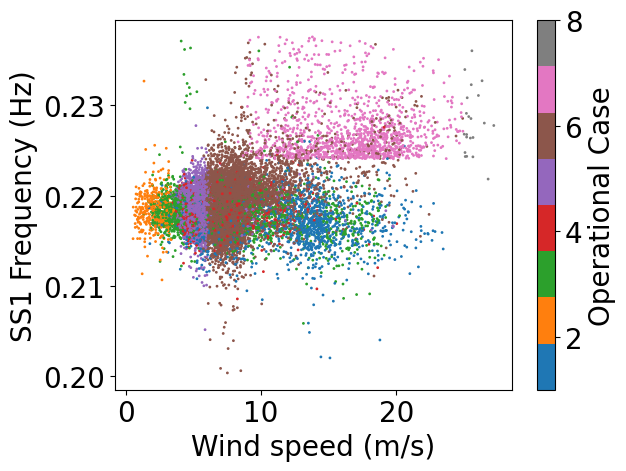

In [23]:
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(X['mean_NW2_C02_windspeed'], y, c=inputs['operational_case'].loc[y.index], s=1, alpha=1.0, cmap=cmap)
plt.ylabel('SS1 Frequency (Hz)')
plt.xlabel('Wind speed (m/s)')
cbar = plt.colorbar()
cbar.set_label('Operational Case')
plt.show()

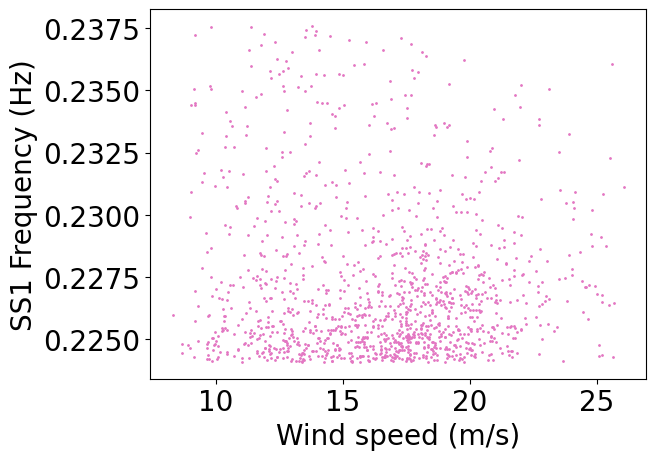

In [36]:
case7 = X[X['mean_NW2_C02_rpm'] > 10.2]
plt.scatter(case7['mean_NW2_C02_windspeed'], y.loc[case7.index], s=1, alpha=1.0, c='tab:pink')
plt.ylabel('SS1 Frequency (Hz)')
plt.xlabel('Wind speed (m/s)')
plt.show()

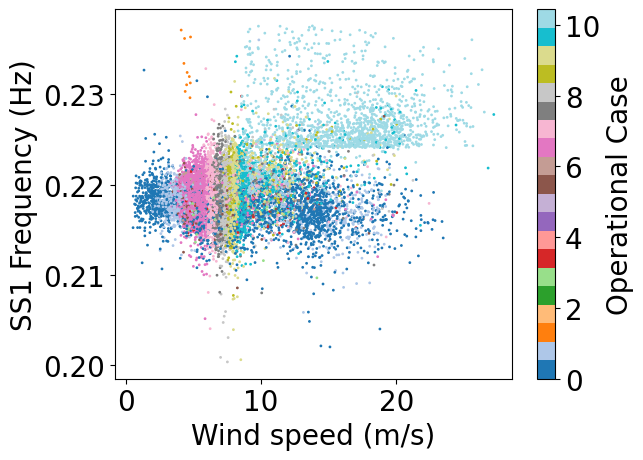

In [26]:
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(X['mean_NW2_C02_windspeed'], y, c=inputs['mean_NW2_C02_rpm'].loc[y.index], s=1, alpha=1.0, cmap='tab20')
plt.ylabel('SS1 Frequency (Hz)')
plt.xlabel('Wind speed (m/s)')
cbar = plt.colorbar()
cbar.set_label('Operational Case')
plt.show()

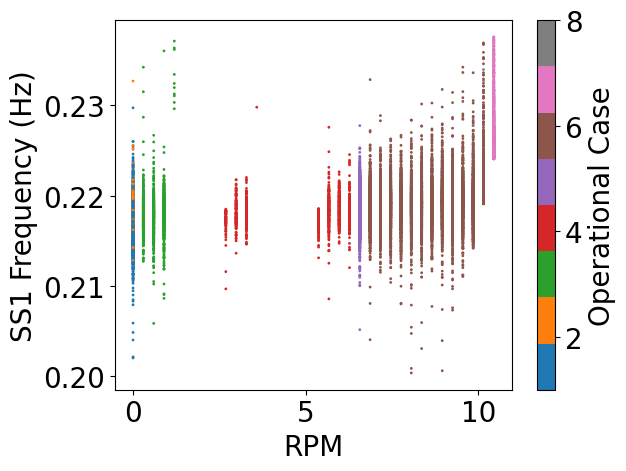

In [22]:
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(X['mean_NW2_C02_rpm'], y, c=inputs['operational_case'].loc[y.index], s=1, alpha=1.0, cmap=cmap)
plt.ylabel('SS1 Frequency (Hz)')
plt.xlabel('RPM')
cbar = plt.colorbar()
cbar.set_label('Operational Case')
plt.show()

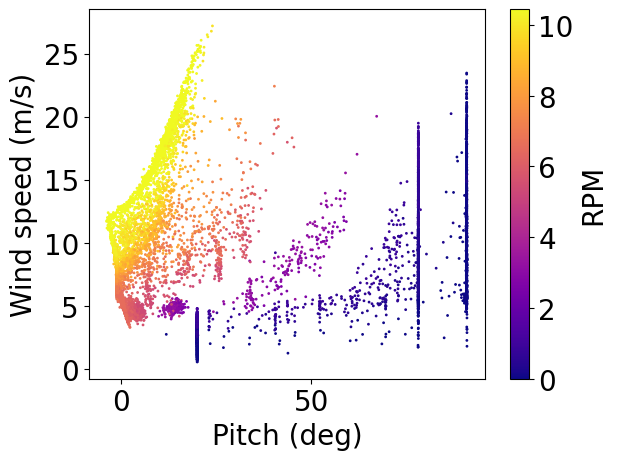

In [15]:
plt.scatter(X['mean_NW2_C02_pitch'], X['mean_NW2_C02_windspeed'], c=X['mean_NW2_C02_rpm'], s=1, alpha=1.0, cmap='plasma')
plt.xlabel('Pitch (deg)')
plt.ylabel('Wind speed (m/s)')
cbar = plt.colorbar()
cbar.set_label('RPM')
plt.show()

In [10]:
# Step 3: Import the Required Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
mode = 'SS1'
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 

y_test_mask = y.isin(y_test_ts)
y_tr_mask = ~y_test_mask
X_tr_ts = X[y_tr_mask]
X_test_ts = X[y_test_mask]
y_tr_ts = y[y_tr_mask]

X_tr_ts_prep, X_test_ts_prep = data_preprocessing(X_tr_ts, X_test_ts)
y_tr_ts_prep, y_test_ts_prep = y_tr_ts.loc[X_tr_ts_prep.index], y_test_ts.loc[X_test_ts_prep.index]

In [12]:
SS1_drop_duplicates.columns

Index(['frequency', 'std_frequency', 'size', 'algorithm', 'case', 'tracked',
       'damping', 'std_damping', 'Turbine'],
      dtype='object')

In [13]:
X_train.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_pitch', 'mean_NW2_C02_power', 'mean_NW2_C02_windspeed',
       'operational_case', 'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
       'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


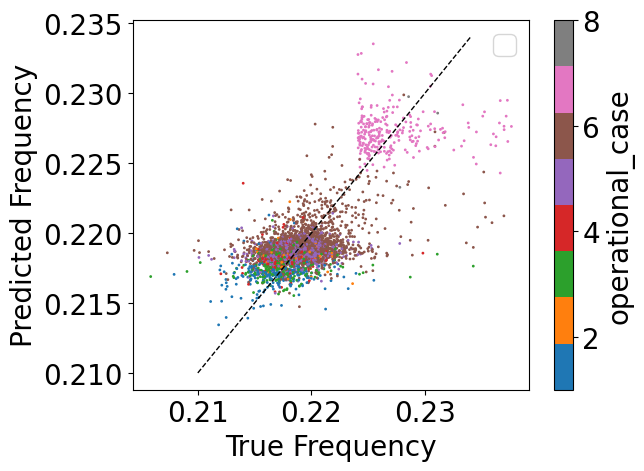

In [103]:


import matplotlib

color_column = 'operational_case'
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)
xgb_regressor_pred = xgb_regressor.predict(X_test)
plt.plot(np.arange(0.21,0.235,0.001), np.arange(0.21,0.235,0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test, xgb_regressor_pred, alpha=1, s=1, c=X_test[color_column], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


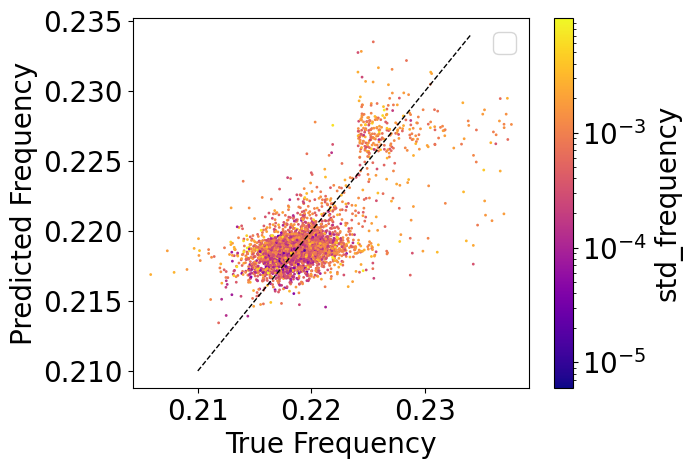

In [90]:
import matplotlib

color_column = 'std_frequency'

xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)
xgb_regressor_pred = xgb_regressor.predict(X_test)
plt.plot(np.arange(0.21,0.235,0.001), np.arange(0.21,0.235,0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test, xgb_regressor_pred, alpha=1, s=1, c=SS1_drop_duplicates.loc[y_test.index][color_column], cmap='plasma',
    norm=matplotlib.colors.LogNorm()
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


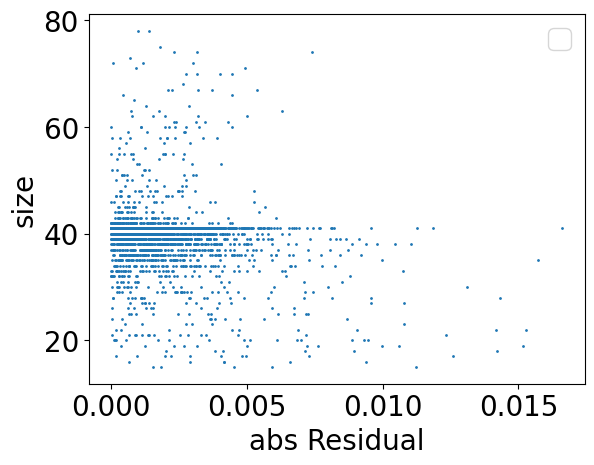

In [93]:
color_column = 'size'
plt.scatter(abs(y_test - xgb_regressor_pred), SS1_drop_duplicates.loc[y_test.index][color_column], s=1)
plt.xlabel('abs Residual')
plt.ylabel(color_column)
plt.legend()

In [ ]:
# Initialize the models
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
neural_network = MLPRegressor()
random_forest = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor()

input_dim = X_train.shape[1]
nn_regressor = Sequential()
nn_regressor.add(Dense(64, activation='relu', input_shape=(input_dim,)))  # Input layer
nn_regressor.add(Dense(64, activation='relu'))  # Hidden layer
nn_regressor.add(Dense(1))  # Output layer

nn_regressor.compile(optimizer='adam', loss='mse')  # Configure the model

# Train the models
linear_regression.fit(X_tr_prep, y_train)
decision_tree.fit(X_train, y_train)
neural_network.fit(X_tr_prep, y_train)
random_forest.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)
nn_regressor.fit(X_tr_prep, y_train, epochs=50, batch_size=32)  # Train the model

# Evaluate the models
linear_regression_pred = linear_regression.predict(X_test_prep)
decision_tree_pred = decision_tree.predict(X_test)
neural_network_pred = neural_network.predict(X_test_prep)
random_forest_pred = random_forest.predict(X_test)
xgb_regressor_pred = xgb_regressor.predict(X_test)
nn_regressor_pred = nn_regressor.predict(X_test_prep)

Epoch 1/50
506/506 [==============================] - 2s 2ms/step - loss: 0.0032
Epoch 2/50
506/506 [==============================] - 1s 2ms/step - loss: 4.9207e-04
Epoch 3/50
506/506 [==============================] - 2s 4ms/step - loss: 2.9543e-04
Epoch 4/50
506/506 [==============================] - 2s 4ms/step - loss: 1.9487e-04
Epoch 5/50
506/506 [==============================] - 1s 3ms/step - loss: 1.5238e-04
Epoch 6/50
506/506 [==============================] - 2s 3ms/step - loss: 1.2606e-04
Epoch 7/50
506/506 [==============================] - 2s 5ms/step - loss: 1.0511e-04
Epoch 8/50
506/506 [==============================] - 2s 4ms/step - loss: 8.9364e-05
Epoch 9/50
506/506 [==============================] - 2s 4ms/step - loss: 6.5650e-05
Epoch 10/50
506/506 [==============================] - 3s 5ms/step - loss: 5.0441e-05
Epoch 11/50
506/506 [==============================] - 3s 6ms/step - loss: 5.0266e-05
Epoch 12/50
506/506 [==============================] - 3s 5ms/step 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Compute the relevant metrics
linear_regression_mse = mean_squared_error(y_test, linear_regression_pred)
decision_tree_mse = mean_squared_error(y_test, decision_tree_pred)
neural_network_mse = mean_squared_error(y_test, neural_network_pred)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
xgb_regressor_mse = mean_squared_error(y_test, xgb_regressor_pred)
nn_regressor_mse = mean_squared_error(y_test, nn_regressor_pred)

linear_regression_r2 = r2_score(y_test, linear_regression_pred)
decision_tree_r2 = r2_score(y_test, decision_tree_pred)
neural_network_r2 = r2_score(y_test, neural_network_pred)
random_forest_r2 = r2_score(y_test, random_forest_pred)
xgb_regressor_r2 = r2_score(y_test, xgb_regressor_pred)
nn_regressor_r2 = r2_score(y_test, nn_regressor_pred)

# Print the metrics
print("Linear Regression MSE:", linear_regression_mse, "R2:", linear_regression_r2)
print("Decision Tree MSE:", decision_tree_mse, "R2:", decision_tree_r2)
print("Neural Network MSE:", neural_network_mse, "R2:", neural_network_r2)
print("Random Forest MSE:", random_forest_mse, "R2:", random_forest_r2)
print("XGB Regressor MSE:", xgb_regressor_mse, "R2:", xgb_regressor_r2)
print("NN Regressor MSE:", nn_regressor_mse, "R2:", nn_regressor_r2)

Linear Regression MSE: 6.185618504494186e-06 R2: 0.42750552388113705
Decision Tree MSE: 1.0774935892903664e-05 R2: 0.0027527118362696834
Neural Network MSE: 0.00027789109635961067 R2: -24.71951657104354
Random Forest MSE: 5.470643964946443e-06 R2: 0.49367820720444877
XGB Regressor MSE: 5.64508807771024e-06 R2: 0.477532967908464
NN Regressor MSE: 5.53458545285051e-06 R2: 0.4877602624438232


In [50]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
XGB_optimizations = {}

seed = 24
def objective_xgb(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,1000),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 500,
            )
    return best
        
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]

100%|██████████| 500/500 [2:04:56<00:00, 14.99s/trial, best loss: 4.912344894383961e-06]  


In [51]:
regr_xgb_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', XGBRegressor(
                            n_estimators = XGB_optimizations[mode]['n_estimators'],
                            max_depth = XGB_optimizations[mode]['max_depth'],
                            learning_rate = XGB_optimizations[mode]['learning_rate'],
                            colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                            )
                        )
                    ]
                )

regr_xgb_optimized.fit(X_tr_ts, y_tr_ts)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test_ts)
regr_xgb_optimized_mse = mean_squared_error(y_test_ts, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test_ts, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

XGBRegressor Optimized MSE: 5.121847299759656e-06 XGBRegressor Optimized R2: 0.5290172740098904


In [15]:
# Catboost

import catboost as cb
cb_reg_1 = cb.CatBoostRegressor(task_type='GPU', verbose=200)


cb_reg_1.fit(X_tr_ts, y_tr_ts)
cb_preds = cb_reg_1.predict(X_test_ts)
cb_mse = mean_squared_error(y_test_ts, cb_preds)
cb_r2 = r2_score(y_test_ts, cb_preds)
print("CB MSE:", cb_mse, "CB R2:", cb_r2)

print(cb_reg_1.get_all_params())

Learning rate set to 0.058162
0:	learn: 0.0031238	total: 136ms	remaining: 2m 15s
200:	learn: 0.0021487	total: 5.73s	remaining: 22.8s
400:	learn: 0.0021169	total: 10.4s	remaining: 15.6s
600:	learn: 0.0020936	total: 15.1s	remaining: 10s
800:	learn: 0.0020821	total: 19.1s	remaining: 4.75s
999:	learn: 0.0020642	total: 23.5s	remaining: 0us
CB MSE: 5.0209478502546564e-06 CB R2: 0.5382955470620753
{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss

In [16]:
# Catboost

import catboost as cb
cb_reg_1 = cb.CatBoostRegressor(task_type='GPU', random_seed=13, verbose=200)


cb_reg_1.fit(X_tr_ts, y_tr_ts)
cb_preds = cb_reg_1.predict(X_test_ts)
cb_mse = mean_squared_error(y_test_ts, cb_preds)
cb_r2 = r2_score(y_test_ts, cb_preds)
print("CB MSE:", cb_mse, "CB R2:", cb_r2)

print(cb_reg_1.get_all_params())

Learning rate set to 0.058162
0:	learn: 0.0031240	total: 30.9ms	remaining: 30.9s
200:	learn: 0.0021576	total: 4.65s	remaining: 18.5s
400:	learn: 0.0021320	total: 8.74s	remaining: 13.1s
600:	learn: 0.0020980	total: 14s	remaining: 9.28s
800:	learn: 0.0020861	total: 19.6s	remaining: 4.87s
999:	learn: 0.0020836	total: 24.1s	remaining: 0us
CB MSE: 5.071783394610815e-06 CB R2: 0.5336209322489437
{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_

In [47]:
import optuna 
def objective_cb(trial):
    params = {
        #"task_type" : "GPU",
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10, log=True),
        "learning_rate": trial.suggest_float("learning_rate",0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_tr_ts, y_tr_ts)
    predictions = model.predict(X_test_ts)
    mse = mean_squared_error(y_test_ts, predictions, squared=True)
    return mse

study = optuna.create_study(direction='minimize', study_name='catboost_optimization')
study.optimize(objective_cb, n_trials=50, n_jobs=-1, timeout=600)

[I 2023-07-18 18:32:09,554] A new study created in memory with name: catboost_optimization
[I 2023-07-18 18:32:13,448] Trial 5 finished with value: 5.478598455805594e-06 and parameters: {'iterations': 890, 'l2_leaf_reg': 8.452016678789336, 'learning_rate': 0.010147495998723154, 'depth': 1}. Best is trial 5 with value: 5.478598455805594e-06.
[I 2023-07-18 18:32:13,812] Trial 0 finished with value: 5.240009582350389e-06 and parameters: {'iterations': 778, 'l2_leaf_reg': 6.208273972867943, 'learning_rate': 0.024781659987329768, 'depth': 2}. Best is trial 0 with value: 5.240009582350389e-06.
[I 2023-07-18 18:32:23,113] Trial 4 finished with value: 5.180641285110575e-06 and parameters: {'iterations': 1962, 'l2_leaf_reg': 5.049415004166581, 'learning_rate': 0.02531128772977433, 'depth': 2}. Best is trial 4 with value: 5.180641285110575e-06.
[I 2023-07-18 18:32:35,228] Trial 8 finished with value: 5.057659405926308e-06 and parameters: {'iterations': 1741, 'l2_leaf_reg': 0.73874384260519, 'lea

In [48]:
print(study.best_value)
print(study.best_params)

5.031199204813286e-06
{'iterations': 1569, 'l2_leaf_reg': 1.5434259070483929, 'learning_rate': 0.013661251615250952, 'depth': 5}


In [49]:
study.best_params
# Catboost

import catboost as cb
cb_reg_opt = cb.CatBoostRegressor(verbose=200, **study.best_params)


cb_reg_opt.fit(X_tr_ts, y_tr_ts)
cb_preds_opt = cb_reg_opt.predict(X_test_ts)
cb_opt_mse = mean_squared_error(y_test_ts, cb_preds_opt)
cb_opt_r2 = r2_score(y_test_ts, cb_preds_opt)
print("CB MSE:", cb_opt_mse, "CB R2:", cb_opt_r2)

0:	learn: 0.0031932	total: 4.17ms	remaining: 6.54s
200:	learn: 0.0022305	total: 648ms	remaining: 4.41s
400:	learn: 0.0021932	total: 1.28s	remaining: 3.74s
600:	learn: 0.0021719	total: 2.05s	remaining: 3.31s
800:	learn: 0.0021517	total: 3.08s	remaining: 2.95s
1000:	learn: 0.0021287	total: 4.23s	remaining: 2.4s
1200:	learn: 0.0021080	total: 5.24s	remaining: 1.61s
1400:	learn: 0.0020897	total: 6.2s	remaining: 743ms
1568:	learn: 0.0020756	total: 7.1s	remaining: 0us
CB MSE: 5.031199204813286e-06 CB R2: 0.5373528772336833


In [ ]:
from hyperopt import space_eval

# bayesian algorithm
algorithm=tpe.suggest

# search for best parameters
best_params = fmin(
  fn=cb_objective,
  space=cb_search_space,
  algo=algorithm,
  max_evals=100)

# dict of the best params
cb_hyperparams = space_eval(cb_search_space, best_params)

100%|██████████| 100/100 [03:54<00:00,  2.34s/trial, best loss: 0.0022421119191257327]


In [ ]:
cb_params = {'learning_rate' : cb_hyperparams['learning_rate'],
          'iterations' : cb_hyperparams['iterations'],
          'depth' : cb_hyperparams['depth'],
          'loss_function' : 'RMSE',
          'l2_leaf_reg' : cb_hyperparams['l2_leaf_reg'],
          'eval_metric' : 'RMSE',
          'early_stopping_rounds': 100,
          'bootstrap_type' : cb_hyperparams['bootstrap_type']}

cb_regr_opt = cb.CatBoostRegressor(**cb_params, task_type='GPU', random_seed=42)
cb_regr_opt.fit(X = X_tr_ts, y = y_tr_ts , verbose=250)
cb_preds_opt = cb_regr_opt.predict(X_test_ts)
cb_mse_opt = mean_squared_error(y_test_ts, cb_preds_opt)
cb_r2_opt = r2_score(y_test_ts, cb_preds_opt)
print("CB Optimized MSE:", cb_mse_opt, "CB Optimized R2:", cb_r2_opt)

0:	learn: 0.0028403	total: 31ms	remaining: 13.7s
250:	learn: 0.0019291	total: 3.89s	remaining: 2.96s
441:	learn: 0.0018117	total: 6.88s	remaining: 0us
CB Optimized MSE: 5.251156436126163e-06 CB Optimized R2: 0.5171265701335405


In [ ]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
RF_optimizations = {}

seed = 24
def objective_rf(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', RandomForestRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 min_samples_split = space['min_samples_split'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_rf(trial):
    space = {
        'n_estimators': hp.uniformint('n_estimators',10,500),
        'max_depth': hp.uniformint('max_depth',2,20),
        'min_samples_split': hp.uniformint('min_samples_split',2,20)
    }
    best = \
        fmin(
            fn = objective_rf,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            )
    return best
        
trial2=Trials()
RF_optimizations[mode] = optimize_rf(trial2)
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]

100%|██████████| 50/50 [2:38:42<00:00, 190.46s/trial, best loss: 4.942946272883003e-06]  


In [ ]:
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]
regr_rf_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', RandomForestRegressor(
                            n_estimators = RF_optimizations[mode]['n_estimators'],
                            max_depth = RF_optimizations[mode]['max_depth'],
                            min_samples_split = RF_optimizations[mode]['min_samples_split']
                            )
                        )
                    ]
                )

regr_rf_optimized.fit(X_tr_ts, y_tr_ts)

regr_rf_optimized_pred = regr_rf_optimized.predict(X_test_ts)
regr_rf_optimized_mse = mean_squared_error(y_test_ts, regr_rf_optimized_pred)
regr_rf_optimized_r2 = r2_score(y_test_ts, regr_rf_optimized_pred)
print("RandomForestRegressor Optimized MSE:", regr_rf_optimized_mse, "RandomForestRegressor Optimized R2:", regr_rf_optimized_r2)

RandomForestRegressor Optimized MSE: 5.133582667299477e-06 RandomForestRegressor Optimized R2: 0.5279381408239674


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_1hiddenlayers",
)
tuner.search_space_summary()

tuner.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 5 Complete [00h 02m 32s]
mean_squared_error: 5.689666522812331e-06

Best mean_squared_error So Far: 5.2300065362942405e-06
Total elapsed time: 00h 12m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner2 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=6,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_2hiddenlayers",
)
tuner2.search_space_summary()

tuner2.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 6 Complete [00h 02m 25s]
mean_squared_error: 5.104195452076965e-06

Best mean_squared_error So Far: 4.914184728477267e-06
Total elapsed time: 00h 16m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner3 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_3hiddenlayers",
)
tuner3.search_space_summary()

tuner3.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 5 Complete [00h 03m 15s]
mean_squared_error: 4.991580681235064e-06

Best mean_squared_error So Far: 4.938730853609741e-06
Total elapsed time: 00h 14m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 1ms/step - loss: 5.3319e-06 - mean_squared_error: 5.3319e-06 - val_loss: 5.5327e-06 - val_mean_squared_error: 5.5327e-06
Epoch 2/100
506/506 [==============================] - 1s 2ms/step - loss: 5.3318e-06 - mean_squared_error: 5.3318e-06 - val_loss: 5.4545e-06 - val_mean_squared_error: 5.4545e-06
Epoch 3/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2799e-06 - mean_squared_error: 5.2799e-06 - val_loss: 5.5643e-06 - val_mean_squared_error: 5.5643e-06
Epoch 4/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2573e-06 - mean_squared_error: 5.2573e-06 - val_loss: 5.4831e-06 - val_mean_squared_error: 5.4831e-06
Epoch 5/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2644e-06 - mean_squared_error: 5.2644e-06 - val_loss: 5.5270e-06 - val_mean_squared_error: 5.5270e-06
Epoch 6/100
506/506 [==============================] - 1s 2ms/step - loss: 5.2845e-06 - mean_squared_erro

In [ ]:
nn1_opt_pred = best_model.predict(X_test_ts_prep)
nn1_opt_mse = mean_squared_error(y_test_ts_prep, nn1_opt_pred)
nn1_opt_r2 = r2_score(y_test_ts_prep, nn1_opt_pred)
print("NN2 Optimized MSE:", nn1_opt_mse, "NN2 Optimized R2:", nn1_opt_r2)

NN2 Optimized MSE: 5.453459152085495e-06 NN2 Optimized R2: 0.4985236952211627


In [ ]:
best_model2 = tuner2.get_best_models()[0]
best_model2.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model2.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 1ms/step - loss: 4.8832e-06 - mean_squared_error: 4.8832e-06 - val_loss: 5.3439e-06 - val_mean_squared_error: 5.3439e-06
Epoch 2/100
506/506 [==============================] - 1s 1ms/step - loss: 4.9166e-06 - mean_squared_error: 4.9166e-06 - val_loss: 5.3992e-06 - val_mean_squared_error: 5.3992e-06
Epoch 3/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8699e-06 - mean_squared_error: 4.8699e-06 - val_loss: 5.3527e-06 - val_mean_squared_error: 5.3527e-06
Epoch 4/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8931e-06 - mean_squared_error: 4.8931e-06 - val_loss: 6.5657e-06 - val_mean_squared_error: 6.5657e-06
Epoch 5/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9039e-06 - mean_squared_error: 4.9039e-06 - val_loss: 5.3466e-06 - val_mean_squared_error: 5.3466e-06
Epoch 6/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8392e-06 - mean_squared_erro

In [ ]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense (Dense)               (None, 120)               1680      
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 16,321
Trainable params: 16,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn2_opt_pred = best_model2.predict(X_test_ts_prep)
nn2_opt_mse = mean_squared_error(y_test_ts_prep, nn2_opt_pred)
nn2_opt_r2 = r2_score(y_test_ts_prep, nn2_opt_pred)
print("NN2 Optimized MSE:", nn2_opt_mse, "NN2 Optimized R2:", nn2_opt_r2)

NN2 Optimized MSE: 5.572620411625559e-06 NN2 Optimized R2: 0.4875661458125289


In [ ]:
best_model3 = tuner3.get_best_models()[0]
best_model3.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model3.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9069e-06 - mean_squared_error: 4.9069e-06 - val_loss: 5.4235e-06 - val_mean_squared_error: 5.4235e-06
Epoch 2/100
506/506 [==============================] - 1s 1ms/step - loss: 4.9366e-06 - mean_squared_error: 4.9366e-06 - val_loss: 5.4725e-06 - val_mean_squared_error: 5.4725e-06
Epoch 3/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8739e-06 - mean_squared_error: 4.8739e-06 - val_loss: 5.7118e-06 - val_mean_squared_error: 5.7118e-06
Epoch 4/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9350e-06 - mean_squared_error: 4.9350e-06 - val_loss: 5.4398e-06 - val_mean_squared_error: 5.4398e-06
Epoch 5/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8809e-06 - mean_squared_error: 4.8809e-06 - val_loss: 6.0955e-06 - val_mean_squared_error: 6.0955e-06
Epoch 6/100
506/506 [==============================] - 1s 1ms/step - loss: 4.8821e-06 - mean_squared_erro

In [ ]:
nn3_opt_pred = best_model3.predict(X_test_ts_prep)
nn3_opt_mse = mean_squared_error(y_test_ts_prep, nn3_opt_pred)
nn3_opt_r2 = r2_score(y_test_ts_prep, nn3_opt_pred)
print("NN2 Optimized MSE:", nn3_opt_mse, "NN2 Optimized R2:", nn3_opt_r2)

NN2 Optimized MSE: 5.898300377274987e-06 NN2 Optimized R2: 0.4576180374358635


# SS2 model selection

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
mode = 'SS1'
df = inputs.copy().dropna()
random_state = 24
test_size = 0.2

prediction_param = SS2_frequency.copy()

operational_cases = df['operational_case'].unique()

# Train Linear Regression Models for Each Case

linear_regression_models = {}
predictions = {}
r2 = {}
mean_squared_errors = {}
y = prediction_param.dropna()
common_indices = df.index.intersection(y.index)
df_case = df.loc[common_indices]

for case in operational_cases:
    print(case)
    
    # Filter the dataset for the current operational case
    case_data = df_case[df_case['operational_case'] == case]
    
    # Split the data into input features (X) and target variable (y)
    y = prediction_param.dropna()
    X = case_data.drop(['operational_case'], axis=1).dropna()
    y = y.loc[X.index]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Train a linear regression model for the current case
    linear_regression = LinearRegression()
    linear_regression.fit(X, y)
    
    # Store the trained linear regression model for the current case
    linear_regression_models[case] = linear_regression
    predictions[case] = linear_regression_models[case].predict(X_test)
    
    r2[case] = r2_score(y_test, predictions[case])
    mean_squared_errors[case] = mean_squared_error(y_test, predictions[case])
    print('R2: ', r2[case], 'MSE: ', mean_squared_errors[case])

# Calculate the overall R2 and MSE for the linear regression model through weighted averaging
r2_overall = 0
mse_overall = 0
for case in operational_cases:
    r2_overall += r2[case] * len(df_case[df_case['operational_case'] == case])
    mse_overall += mean_squared_errors[case] * len(df_case[df_case['operational_case'] == case])
r2_overall /= len(df_case)
mse_overall /= len(df_case)

print('Overall R2: ', r2_overall)
print('Overall MSE: ',mse_overall)

7.0
R2:  0.10224810861867051 MSE:  0.00023839555951553167
6.0
R2:  0.5068495354444917 MSE:  8.361230922894417e-05
5.0
R2:  0.12076283325783232 MSE:  4.555814741948732e-05
4.0
R2:  0.18851296733704148 MSE:  0.00043503933625374373
3.0
R2:  0.6722848887921353 MSE:  7.036312111259612e-05
2.0
R2:  0.8015156882599725 MSE:  4.694258044871343e-05
1.0
R2:  0.6913460758079315 MSE:  7.379214443750716e-05
8.0
R2:  1.0 MSE:  1.5777218104420236e-30
Overall R2:  0.47166855665922935
Overall MSE:  0.00012821453103027013


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(inputs['mean_NW2_C02_windspeed'], inputs['mean_NW2_C02_rpm'], alpha=0.1, c=inputs['operational_case'], cmap=cmap)

In [ ]:
inputs.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'mean_NW2_C02_winddirection',
       'operational_case'],
      dtype='object')

In [ ]:
np.linspace(int(inputs['operational_case'].min()), int(inputs['operational_case'].max()), int(2 * len(inputs['operational_case'].unique()) + 1))[1::2]

array([1.38888889, 2.16666667, 2.94444444, 3.72222222, 4.5       ,
       5.27777778, 6.05555556, 6.83333333, 7.61111111])

In [ ]:
int(2 * len(inputs['operational_case'].unique()) + 1)

19